# Cell State Dissection

Using ideas from the FineClustering analysis to dissect the major cell states in the data.

In [2]:
library(SnapATAC)
library(reshape2)
library(viridis)
library(scales)
library(ggplot2)
library(ggrepel)
library(DESeq2)
library(ClusterR)
library(RColorBrewer)
library(patchwork)
library(cowplot)
library(edgeR)

Loading required package: Matrix

Loading required package: rhdf5

Loading required package: viridisLite


Attaching package: ‘scales’


The following object is masked from ‘package:viridis’:

    viridis_pal


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:SnapATAC’:

    colMeans, colSums, rowMeans, rowSums


The following objects are masked from ‘package:Matrix’:

    colMeans, colSums, rowMeans, rowSums, which


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated,

In [3]:
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

In [4]:
DAYS = c()
FILE_PREFIX = "/srv/scratch/surag/scATAC-reprog/snap"

file.list = c()
barcode.file.list = c()

for (i in seq(0, 14, 2)) {
    DAYS = c(DAYS, sprintf("D%d", i))
    file.list = c(file.list, sprintf("%s/D%d.snap", FILE_PREFIX, i))
}
DAYS
file.list

[1] "D0"  "D2"  "D4"  "D6"  "D8"  "D10" "D12" "D14"

[1] "/srv/scratch/surag/scATAC-reprog/snap/D0.snap" 
[2] "/srv/scratch/surag/scATAC-reprog/snap/D2.snap" 
[3] "/srv/scratch/surag/scATAC-reprog/snap/D4.snap" 
[4] "/srv/scratch/surag/scATAC-reprog/snap/D6.snap" 
[5] "/srv/scratch/surag/scATAC-reprog/snap/D8.snap" 
[6] "/srv/scratch/surag/scATAC-reprog/snap/D10.snap"
[7] "/srv/scratch/surag/scATAC-reprog/snap/D12.snap"
[8] "/srv/scratch/surag/scATAC-reprog/snap/D14.snap"

In [5]:
x.sp.ls = lapply(seq(file.list), function(i) {
    x.sp = createSnap(file = file.list[i],                      
                     sample = DAYS[i])
    x.sp
})

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...



In [6]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200206_pmat_snapATAC/sessions/20200220_n74838/metadata.tsv", header = T)
metaData$barcode = lapply(strsplit(rownames(metaData), '_'), "[[", 2)
metaData = metaData[order(rownames(metaData)), ]
head(metaData, 2)

sample umap.1   umap.2    cluster barcode         
D0_AAACAACGACGATTAC D0     6.545686 -7.701751 2       AAACAACGACGATTAC
D0_AAACAACGACTCACGG D0     5.180663 -7.633298 2       AAACAACGACTCACGG

In [7]:
# Filter cells 
x.sp.list = lapply(seq(x.sp.ls), function(i){
  x.sp = x.sp.ls[[i]];
  x.sp  = x.sp[x.sp@barcode %in% metaData[as.character(metaData$sample)==DAYS[i], "barcode"],];
})
names(x.sp.list) = DAYS;

In [8]:
x.sp.list = lapply(seq(x.sp.list), function(i) {
    x.sp = addPmatToSnap(x.sp.list[[i]], num.cores=5)
    x.sp
})

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...



In [9]:
# merge timepoints
x.sp = Reduce(snapRbind, x.sp.list);

Warning message:
“'rBind' is deprecated.
 Since R version 3.2.0, base's rbind() should work fine with S4 objects”


In [10]:
# order by sample_barcode
x.sp = x.sp[order(paste(x.sp@sample, x.sp@barcode, sep='_')), ]

In [11]:
# Note that the peaks matrix is not binarized

In [12]:
x.sp@cluster = factor(metaData$cluster)
slot(x.sp, "umap") = as.matrix(metaData[, c("umap.1", "umap.2")])

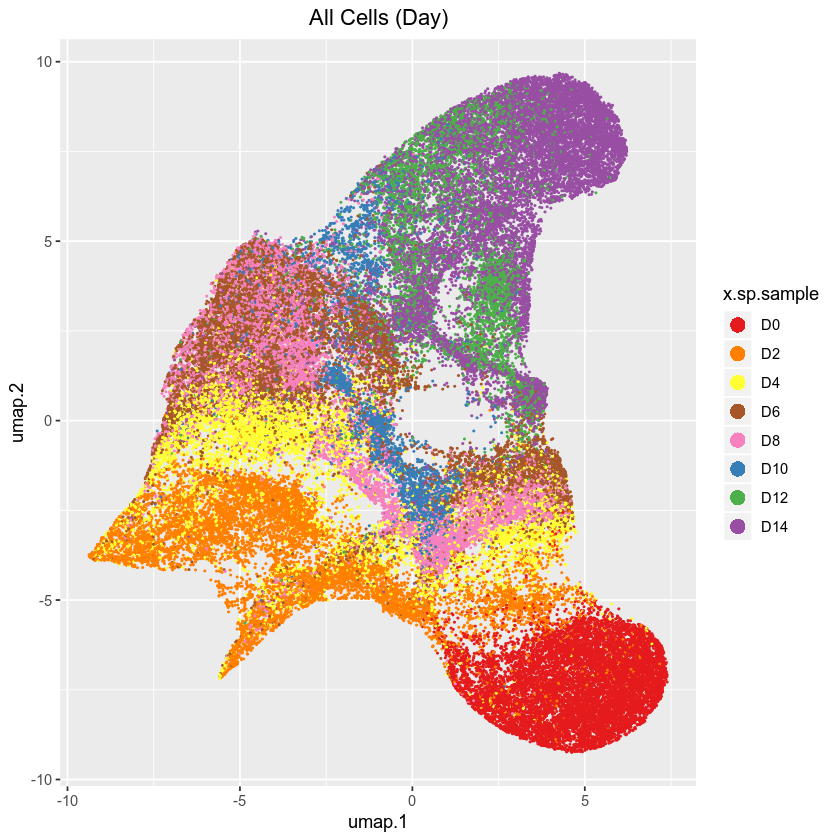

In [1282]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, x.sp@sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=x.sp.sample)) +
scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

## Finer Clustering

In [14]:
library(RANN)
library(leiden)

In [15]:
feats = read.table("../20200206_pmat_snapATAC/sessions/20200220_n74838/features.tsv", header = T)
feats = feats[order(rownames(feats)),]
feats = feats[, 5:ncol(feats)]
head(feats,3)

X1           X2          X3          X4          
D0_AAACAACGACGATTAC -0.009506306 0.003827220 0.004101834 -0.009462710
D0_AAACAACGACTCACGG -0.009003734 0.002892498 0.004525334 -0.004391663
D0_AAACAACGAGCGCACT -0.009416234 0.003781612 0.004398451 -0.006866973
                    X5           X6           X7          X8         
D0_AAACAACGACGATTAC 0.0016989356 -0.006388548 0.004262987 0.003578299
D0_AAACAACGACTCACGG 0.0009756110 -0.010070413 0.005721408 0.003989271
D0_AAACAACGAGCGCACT 0.0005773408 -0.007889277 0.005984896 0.004210641
                    X9           
D0_AAACAACGACGATTAC -0.0055907033
D0_AAACAACGACTCACGG  0.0005145822
D0_AAACAACGAGCGCACT -0.0032638603

In [16]:
K = 15

nn.ranked <- nn2(
        data = feats,
        k = K,
        searchtype = 'standard',
        eps = 0)$nn.idx;

j <- as.numeric(x = t(x = nn.ranked))
i <- ((1:length(x = j)) - 1) %/% K + 1
edgeList = data.frame(i, j, 1);
kmat = Matrix(0, nrow(feats), nrow(feats), sparse=TRUE);
kmat = sparseMatrix(i = edgeList[,1], j = edgeList[,2], x = edgeList[,3]);
nn_graph = SnapATAC:::newKgraph(mat=kmat, k=K, snn=FALSE, snn.prune=1/15);

In [17]:
clusters = leiden(SnapATAC:::getGraph(nn_graph), resolution=2)

In [18]:
table(clusters)

clusters
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
3862 3690 3559 3260 3160 3039 2917 2742 2668 2625 2586 2522 2504 2485 2466 2461 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
2445 2256 2151 2067 1941 1836 1829 1763 1758 1666 1663 1640 1282 1247 1113  859 
  33 
 776 

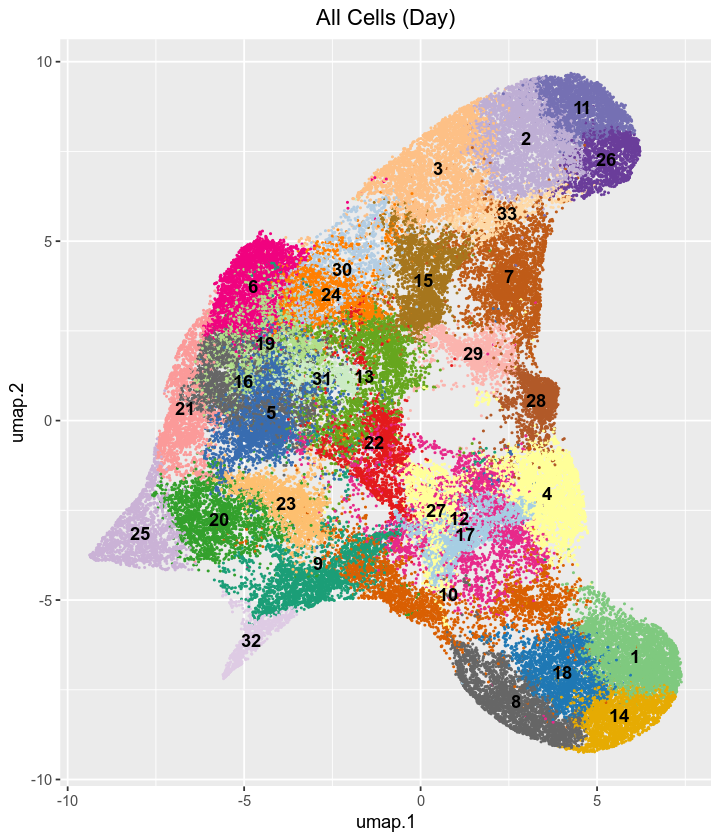

In [830]:
options(repr.plot.width = 6, repr.plot.height = 7)

df = data.frame(x.sp@umap, clst=as.factor(clusters))
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=clst)) +
# scale_color_brewer( palette = "Set1") +
scale_color_manual(values=col_vector) +
geom_text(data=data.frame(aggregate(x.sp@umap, list(clusters), mean)),
         aes(x=umap.1, y=umap.2, label=Group.1), fontface = "bold") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5),
      legend.positio = "none")
# guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

In [1409]:
table(x.sp@sample[clusters=="4"])


  D0  D10  D12  D14   D2   D4   D6   D8 
  15    4   37   38   74  832 1445  815 

## Make pseudo-bulk matrix

In [20]:
agg_matrix = sparseMatrix(i=clusters,
                         j=seq(1,nrow(x.sp)),
                         x=1L,
                         dims=c(length(table(clusters)), nrow(x.sp)))

In [21]:
cts = as.matrix(agg_matrix %*% x.sp@pmat)
colnames(cts) = as.character(x.sp@peak)
rownames(cts) = paste("cluster", seq(1,nrow(cts)), sep="_")
cts = t(cts)
head(cts)

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5 cluster_6
chr1:16147-16347    7         9         7         5        16         5       
chr1:51459-51659    0         3         0         0         1         0       
chr1:51689-52109    1        13        18         0         3         2       
chr1:180686-181260 47        29        21        25        67        31       
chr1:181268-181597 30        54        21        10        66        35       
chr1:184385-184585 11         7        10         5        30        10       
                   cluster_7 cluster_8 cluster_9 cluster_10 ⋯ cluster_24
chr1:16147-16347    5        14         6         0         ⋯  6        
chr1:51459-51659    1         1         0         0         ⋯  0        
chr1:51689-52109    6         1         0         0         ⋯  0        
chr1:180686-181260 35        52        11         8         ⋯ 23        
chr1:181268-181597 54        29        27        10         ⋯ 18        
chr1:184385-184585 13         9        12        13         ⋯  7        
                   cluster_25 cluster_26 cluster_27 cluster_28 cluster_29
chr1:16147-16347    0          2          3         2          1         
chr1:51459-51659    0          0          0         1          0         
chr1:51689-52109    0          1          0         0          0         
chr1:180686-181260 16         18         15         3          5         
chr1:181268-181597 16         20         26         5          8         
chr1:184385-184585  4          0         10         2          5         
                   cluster_30 cluster_31 cluster_32 cluster_33
chr1:16147-16347    6          8          0          0        
chr1:51459-51659    2          0          0          0        
chr1:51689-52109    3          2          0          0        
chr1:180686-181260 28         27          1          9        
chr1:181268-181597 35         33         15         11        
chr1:184385-184585  9         24          5          0

In [22]:
cts = cts[rowSums(cts)>50, ]
dim(cts)

[1] 457477     33

In [23]:
norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts))

In [24]:
log_norm_cts = log2(1+norm_cts)

## Clustering etc

In [25]:
PLOT_CLSTS = colnames(norm_cts) #c("cluster_1", "cluster_10", "cluster_26", "cluster_6")
CLST_BASIS = PLOT_CLSTS
# CLST_BASIS = c("cluster_1", "cluster_10", "cluster_26")
cts_to_cluster = log2(1+200*(norm_cts/width(GRanges(rownames(norm_cts)))))
# cts_to_cluster = t(scale(t(log_norm_cts)))

In [634]:
# ADD RAND SEED - not required

km_mb = MiniBatchKmeans(cts_to_cluster[,CLST_BASIS], 
                        batch_size = 1000,
                        clusters=15,
                        num_init = 10, 
                        verbose = FALSE)

In [635]:
# reorder based on hierarchical clustering
# pr_mb = predict_MBatchKMeans(cts_to_cluster, km_mb$centroids)

# distance    = dist(t(scale(t(km_mb$centroids))))
# cluster     = hclust(distance, method="ward")
# dendrogram  = as.dendrogram(cluster)
# rowInd = rev(order.dendrogram(dendrogram))
# pr_mb = order(rowInd)[pr_mb]

In [636]:
# no hierarchical clustering, follow order of km_mb$centroids
pr_mb = predict_MBatchKMeans(cts_to_cluster[, CLST_BASIS], km_mb$centroids)

In [637]:
table(pr_mb)

pr_mb
    1     2     3     4     5     6     7     8     9    10    11    12    13 
15686 38535 21933 24700 33405 35399 44535 17831 22244 32609 34596 33936 38920 
   14    15 
29954 33194 

In [638]:
order(rowVars(km_mb$centroids))

[1]  5  1  2  6 15 11 14 12 13  7 10  4  3  9  8

In [639]:
cts_clustered = cts_to_cluster[order(pr_mb),]
head(cts_clustered, 2)

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5 cluster_6
chr1:633905-634268 5.799924  5.906914  8.055269  9.533027  8.212103  9.915293 
chr1:778297-778948 7.199558  7.191567  6.630632  6.497154  6.675978  6.256913 
                   cluster_7 cluster_8 cluster_9 cluster_10 ⋯ cluster_25
chr1:633905-634268 6.174999  8.095988  8.530713  7.099929   ⋯ 8.131771  
chr1:778297-778948 7.309356  6.366978  6.313137  6.759074   ⋯ 6.517724  
                   cluster_26 cluster_27 cluster_28 cluster_29 cluster_30
chr1:633905-634268 7.870408   7.796643   8.667458   7.257731   8.260799  
chr1:778297-778948 6.647489   6.840683   6.621128   6.535793   6.675498  
                   cluster_31 cluster_32 cluster_33 cluster_34
chr1:633905-634268 7.340751   6.528611   7.292625   7.803046  
chr1:778297-778948 6.955355   6.737744   6.353300   6.494609

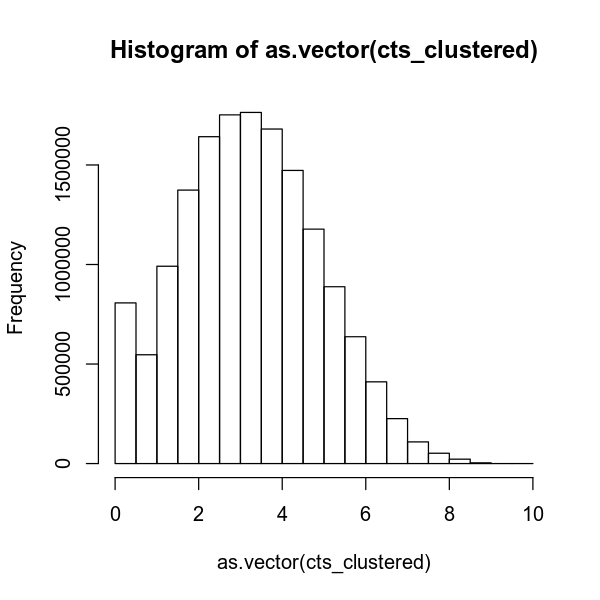

In [640]:
options(repr.plot.width = 5, repr.plot.height = 5)
hist(as.vector(cts_clustered))

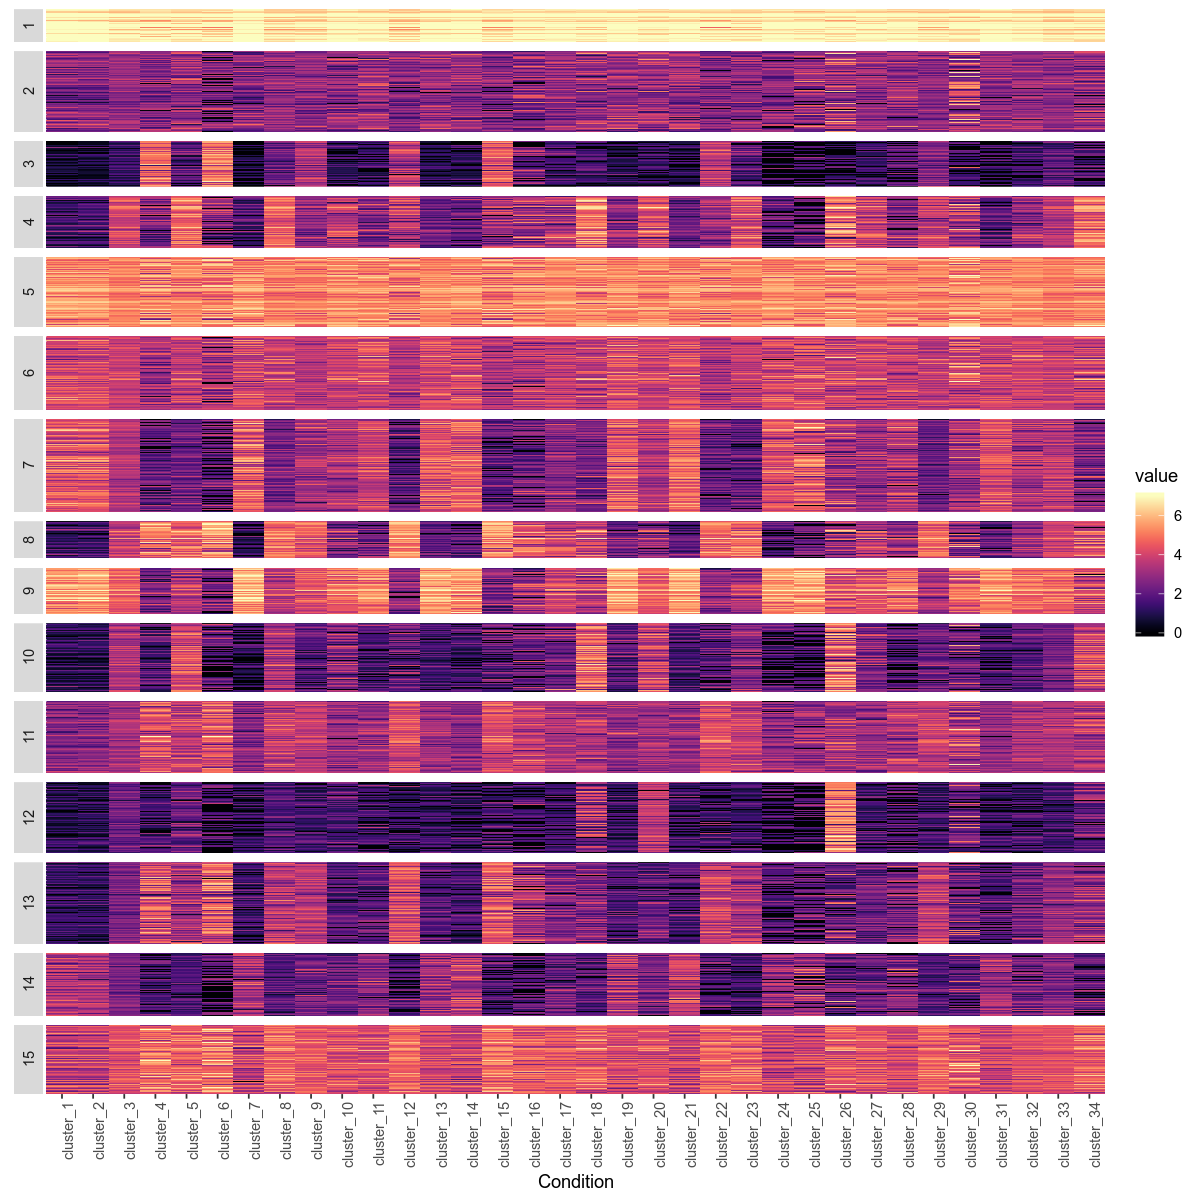

In [645]:
options(repr.plot.width = 10, repr.plot.height = 10)

idxs = seq(1, nrow(cts_clustered), 10) # if subsample
ggplot(data = melt(cts_clustered[idxs, ]), 
       mapping = aes(x = Var2,
                     y = Var1,
                     fill = value)) +
geom_tile()  + ylab(NULL) + xlab("Condition") +  
geom_raster(aes(fill=value)) +
scale_fill_viridis(limits=c(0, 7), oob=squish, option = "A") +
# scale_fill_viridis(option="A") + 
# scale_fill_gradient2(low="red", mid="black", high="blue") +
facet_grid(sort(pr_mb)[idxs] ~ ., switch = "y", scales = "free_y", space = "free_y")+
# theme_classic() +
theme(axis.text.x=element_text(angle=90,hjust=1),
      axis.text.y=element_blank(),
      axis.ticks.y=element_blank()) 
#       panel.spacing.y = unit(0.03, "cm"),
#       strip.text.y = element_text(size = 3))  
#       strip.background = element_rect(size = 0.1))

# ggsave(sprintf("figs/%s_tmp_heatmap_n%d.jpeg", format(Sys.Date(), format='%Y%m%d'), length(table(pr_mb))),
#        dpi=1000)

In [360]:
CLUSTER_IDX = 1
NORM = 'tmp'
BED_PATH = sprintf("beds/%s_%s_n%d/idx%d.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), CLUSTER_IDX)
# rownames(vsd_assay_to_cluster_normalized)[(which(pr_mb==CLUSTER_IDX))]
BED_PATH

[1] "beds/20200328_tmp_n20/idx1.bed"

In [361]:
for (i in seq(1,length(table(pr_mb)))){
BED_PATH = sprintf("beds/%s_%s_n%d/idx%d.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), i)
fileConn = file(BED_PATH)
writeLines(sub('-', '\t', sub(':', '\t', rownames(cts_to_cluster)))[(which(pr_mb==i))], fileConn)
close(fileConn)}

In [362]:
ALL_PEAKS_BED_PATH = sprintf("beds/%s_%s_n%d/all_peaks.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)))
print(ALL_PEAKS_BED_PATH)
fileConn = file(ALL_PEAKS_BED_PATH)
writeLines(sub('-', '\t', sub(':', '\t', rownames(cts_to_cluster))), fileConn)
close(fileConn)

[1] "beds/20200328_tmp_n20/all_peaks.bed"


## Gene Scores

In [514]:
edb <- EnsDb.Hsapiens.v86

In [517]:
# using these for gene names since refGene has many non-coding genes etc
edb.genes.hg38 = genes(edb, column = "gene_name", filter = GeneBiotypeFilter("protein_coding"))
seqlevels(edb.genes.hg38) = paste("chr", seqlevels(edb.genes.hg38), sep='')

In [360]:
txdb = makeTxDbFromGFF("/users/surag/kundajelab/scATAC-reprog/resources/refGene/hg38.refGene.gtf.gz", format="gtf")

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(type, phase):
"The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored."
OK



In [518]:
tx.hg38 = transcripts(txdb, columns = c("gene_id", "tx_name"))
tx.hg38$gene_id = unlist(tx.hg38$gene_id)
tx.hg38 = tx.hg38[tx.hg38$gene_id %in% edb.genes.hg38$gene_name] # a hack to remove non-coding transcripts
tx.hg38

GRanges object with 67868 ranges and 2 metadata columns:
                     seqnames        ranges strand |     gene_id        tx_name
                        <Rle>     <IRanges>  <Rle> | <character>    <character>
      [1]                chr1   69091-70008      + |       OR4F5   NM_001005484
      [2]                chr1 925731-944574      + |      SAMD11      NM_152486
      [3]                chr1 960584-965719      + |      KLHL17      NM_198317
      [4]                chr1 966482-975865      + |     PLEKHN1   NM_001160184
      [5]                chr1 966482-975865      + |     PLEKHN1   NM_001367552
      ...                 ...           ...    ... .         ...            ...
  [67864] chrX_KI270881v1_alt   65309-82330      - |       TBX22 NM_001109878_2
  [67865] chrX_KI270881v1_alt   65309-82330      - |       TBX22   NM_001109879
  [67866] chrX_KI270881v1_alt   65314-74023      - |       TBX22   NM_001303475
  [67867] chrX_KI270881v1_alt   65314-74840      - |       TBX2

In [519]:
tss.hg38 = unique(resize(tx.hg38, width=1, fix='start'))
tss.hg38

GRanges object with 33771 ranges and 2 metadata columns:
                     seqnames    ranges strand |     gene_id        tx_name
                        <Rle> <IRanges>  <Rle> | <character>    <character>
      [1]                chr1     69091      + |       OR4F5   NM_001005484
      [2]                chr1    925731      + |      SAMD11      NM_152486
      [3]                chr1    960584      + |      KLHL17      NM_198317
      [4]                chr1    966482      + |     PLEKHN1   NM_001160184
      [5]                chr1   1013497      + |       ISG15      NM_005101
      ...                 ...       ...    ... .         ...            ...
  [33767] chrX_KI270880v1_alt     70260      - |     PPP2R3B    NM_013239_2
  [33768] chrX_KI270881v1_alt     82330      - |       TBX22 NM_001109878_2
  [33769] chrX_KI270881v1_alt     74023      - |       TBX22   NM_001303475
  [33770] chrX_KI270881v1_alt     74840      - |       TBX22      NM_016954
  [33771] chrX_KI270913v1_alt  

In [520]:
prom.hg38 = promoters(tss.hg38, upstream = 2000, downstream = 500)
prom.hg38

GRanges object with 33771 ranges and 2 metadata columns:
                     seqnames          ranges strand |     gene_id
                        <Rle>       <IRanges>  <Rle> | <character>
      [1]                chr1     67091-69590      + |       OR4F5
      [2]                chr1   923731-926230      + |      SAMD11
      [3]                chr1   958584-961083      + |      KLHL17
      [4]                chr1   964482-966981      + |     PLEKHN1
      [5]                chr1 1011497-1013996      + |       ISG15
      ...                 ...             ...    ... .         ...
  [33767] chrX_KI270880v1_alt     69761-72260      - |     PPP2R3B
  [33768] chrX_KI270881v1_alt     81831-84330      - |       TBX22
  [33769] chrX_KI270881v1_alt     73524-76023      - |       TBX22
  [33770] chrX_KI270881v1_alt     74341-76840      - |       TBX22
  [33771] chrX_KI270913v1_alt     58901-61400      - |     PPP2R3B
                 tx_name
             <character>
      [1]   NM_0010054

In [598]:
unique_prom_genes = names(table(prom.hg38$gene_id)[which(table(prom.hg38$gene_id)==1)])

In [521]:
intervals_gr = GRanges(rownames(cts))

### Promoters Only

In [522]:
overlaps = findOverlaps(prom.hg38, intervals_gr)
overlaps

Hits object with 52431 hits and 0 metadata columns:
          queryHits subjectHits
          <integer>   <integer>
      [1]         2          50
      [2]         2          51
      [3]         2          52
      [4]         2          53
      [5]         2          54
      ...       ...         ...
  [52427]     29567      456915
  [52428]     29569      457261
  [52429]     29569      457262
  [52430]     29577      457451
  [52431]     29578      457451
  -------
  queryLength: 33771 / subjectLength: 457477

In [523]:
summed_gene = aggregate(cts[subjectHits(overlaps),], list(queryHits(overlaps)), sum)

rownames(summed_gene) = paste(prom.hg38[summed_gene$Group.1]$gene_id, prom.hg38[summed_gene$Group.1]$tx_name, sep=':')
summed_gene$Group.1 = NULL

# DESeq2 normalize
summed_gene = as.data.frame(t(t(summed_gene)/estimateSizeFactorsForMatrix(summed_gene)))

head(summed_gene)

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5
SAMD11:NM_152486     444.6711  277.3524  295.6893  608.8522  453.7027 
KLHL17:NM_198317     497.2714  369.0484  306.7525  498.6499  451.9960 
PLEKHN1:NM_001160184 339.9126  286.4088  232.3273  451.7683  405.3457 
ISG15:NM_005101      392.5129  302.2575  228.3043  452.9860  396.2432 
AGRN:NM_001305275    590.5374  322.6344  296.6950  609.4610  510.3089 
AGRN:NM_001364727    338.1446  662.2495  520.9763  411.5841  498.0774 
                     cluster_6 cluster_7 cluster_8 cluster_9 cluster_10 ⋯
SAMD11:NM_152486     399.9100  405.8206  417.0445  486.2594  505.1145   ⋯
KLHL17:NM_198317     445.9638  371.8389  534.3947  456.0214  450.9382   ⋯
PLEKHN1:NM_001160184 272.8249  360.7295  445.0280  580.2423  658.0830   ⋯
ISG15:NM_005101      306.0536  372.4924  381.3881  410.2558  449.3448   ⋯
AGRN:NM_001305275    450.0445  355.5015  616.9912  535.2940  564.0711   ⋯
AGRN:NM_001364727    581.7933  533.2523  374.1666  514.8629  441.3777   ⋯
                     cluster_24 cluster_25 cluster_26 cluster_27 cluster_28
SAMD11:NM_152486     419.3669   493.3123   476.6840   474.9043   587.4157  
KLHL17:NM_198317     417.3162   475.9013   448.2724   527.0071   372.6616  
PLEKHN1:NM_001160184 275.8183   367.9529   359.8807   610.7132   577.9413  
ISG15:NM_005101      333.2377   343.5775   391.4491   480.8833   457.9316  
AGRN:NM_001305275    472.6849   425.9897   457.7429   590.2137   410.5594  
AGRN:NM_001364727    547.5352   529.2951   890.2311   418.5307   369.5034  
                     cluster_29 cluster_30 cluster_31 cluster_32 cluster_33
SAMD11:NM_152486     585.3366   428.3203   438.7673    727.9786  402.5529  
KLHL17:NM_198317     399.2296   434.8100   462.5001    503.9852  492.5353  
PLEKHN1:NM_001160184 438.2520   395.0606   494.3368    584.4828  279.4190  
ISG15:NM_005101      324.1864   331.7860   399.9845    346.4898  388.3451  
AGRN:NM_001305275    441.2538   455.9015   492.6003    668.4804  497.2712  
AGRN:NM_001364727    618.3556   565.4152   518.0696   1158.4660  838.2571

### Inverse Distance Model

In [524]:
distal_overlaps = findOverlaps(tss.hg38+100000, intervals_gr)
distal_overlaps

Hits object with 1323598 hits and 0 metadata columns:
            queryHits subjectHits
            <integer>   <integer>
        [1]         1           1
        [2]         1           2
        [3]         2          26
        [4]         2          27
        [5]         2          28
        ...       ...         ...
  [1323594]     29578      457456
  [1323595]     29578      457457
  [1323596]     29578      457458
  [1323597]     29578      457459
  [1323598]     29579      457473
  -------
  queryLength: 33771 / subjectLength: 457477

In [525]:
distal_summed_gene = cts[subjectHits(distal_overlaps),]

gene_peak_coeff = 1000*(1+abs(mid(intervals_gr[subjectHits(distal_overlaps)]) - start(tss.hg38[queryHits(distal_overlaps)])))^(-0.7)

distal_summed_gene = aggregate(gene_peak_coeff * distal_summed_gene, list(queryHits(distal_overlaps)), sum)

# remove genes with duplicate entries
rownames(distal_summed_gene) = paste(prom.hg38[distal_summed_gene$Group.1]$gene_id, prom.hg38[distal_summed_gene$Group.1]$tx_name, sep=':')
distal_summed_gene$Group.1 = NULL

# DESeq2 normalize
distal_summed_gene = as.data.frame(t(t(distal_summed_gene)/estimateSizeFactorsForMatrix(distal_summed_gene)))

head(distal_summed_gene, 2)

cluster_1    cluster_2  cluster_3  cluster_4    cluster_5   
OR4F5:NM_001005484     2.058984   20.84553   22.93676     1.527506     3.174567
SAMD11:NM_152486   13008.477832 8385.80038 9000.24298 16564.884144 14045.280403
                   cluster_6    cluster_7    cluster_8   cluster_9   
OR4F5:NM_001005484     2.645919     5.887062     3.66679     2.414521
SAMD11:NM_152486   13621.609456 11533.825152 11848.15229 16204.788055
                   cluster_10 ⋯ cluster_24   cluster_25 cluster_26  
OR4F5:NM_001005484     0.00   ⋯     3.052577     0.00       6.574318
SAMD11:NM_152486   14666.65   ⋯ 12998.345671 16385.53   13286.893407
                   cluster_27   cluster_28   cluster_29   cluster_30  
OR4F5:NM_001005484     1.270447     3.113449     1.505052     5.041923
SAMD11:NM_152486   12451.557592 16263.450018 15928.522103 13004.075581
                   cluster_31   cluster_32 cluster_33
OR4F5:NM_001005484     3.528715     0.00       0.00  
SAMD11:NM_152486   12448.676832 25226.49   10446.38

In [1276]:
rownames(distal_summed_gene)[grep("TCF12", rownames(distal_summed_gene))]

[1] "TCF12:NM_001322151" "TCF12:NM_001322152" "TCF12:NM_001322161"
[4] "TCF12:NM_001322164" "TCF12:NM_001306219"

In [1277]:
GENE = "TCF12:NM_001322151"

In [1278]:
# distal_summed_gene[GENE, ]
summed_gene[GENE, ]

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5 cluster_6
TCF12:NM_001322151 610.4283  543.3842  577.2981  625.9     551.2701  547.3987 
                   cluster_7 cluster_8 cluster_9 cluster_10 ⋯ cluster_24
TCF12:NM_001322151 545.0152  605.7075  543.4664  565.6645   ⋯ 570.0929  
                   cluster_25 cluster_26 cluster_27 cluster_28 cluster_29
TCF12:NM_001322151 518.8485   571.3895   597.0469   568.4668   534.3073  
                   cluster_30 cluster_31 cluster_32 cluster_33
TCF12:NM_001322151 599.4862   618.2104   430.4874   573.0458

In [1279]:
max(distal_summed_gene[GENE, ])/min(distal_summed_gene[GENE, ])
max(summed_gene[GENE, ])/min(summed_gene[GENE, ])

[1] 1.591893

[1] 1.581666

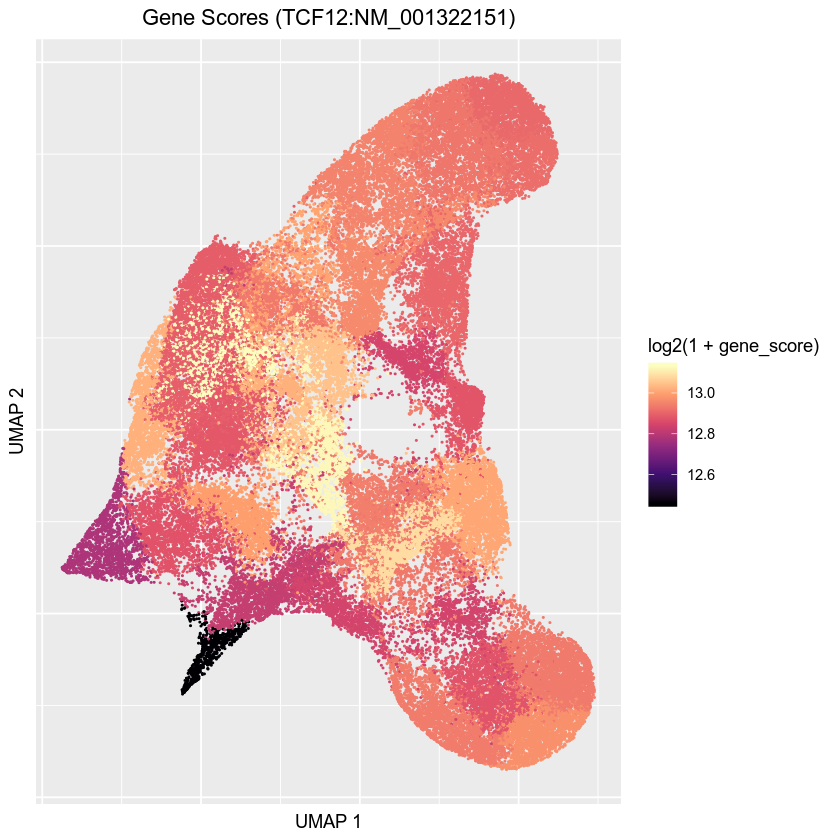

In [1280]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, gene_score=as.numeric(distal_summed_gene[GENE, ])[clusters])
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=log2(1+gene_score))) +
ggtitle(sprintf("Gene Scores (%s)", GENE)) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(oob=squish, option = "A") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

## Cell State Dissection - Playground

In [1366]:
# load bulk RNA-seq data
fpkm = read.table("/users/surag/kundajelab/scATAC-reprog/resources/GSE62777/RNAseq.FPKM.tsv", sep='\t', header=T)
fpkm$gene_id = NULL
fpkm$locus=NULL
tpm = fpkm
tpm[,2:ncol(tpm)] = 1e6*t(t(tpm[,2:ncol(tpm)])/colSums(tpm[,2:ncol(tpm)]))

# removing genes with dup names
tpm = tpm[!duplicated(tpm$gene_short_name),]
rownames(tpm) = tpm$gene_short_name
tpm$gene_short_name = NULL

tpm["GAPDH",]

hiF.T_P14 X2dd_DOX_plus X5dd_DOX_plus X8dd_DOX_plus
GAPDH 7803.64   4963.505      3908.693      3839.776     
      X10dd_DOX_plus_SSEA3_pos X14dd_DOX_plus_SSEA3_pos X20dd_DOX_plus_TRA_plus
GAPDH 3795.548                 3364.503                 3032.412               
      X24dd_TRA_pos_DOX_plus X24dd_TRA_pos_DOX_minus hIPSC.T_P10
GAPDH 3790.955               5598.224                4731.256

In [1576]:
data.use = summed_gene
group = factor(colnames(data.use), levels = colnames(data.use))
y = DGEList(counts=data.use, group=group)

In [1577]:
design <- model.matrix(~0+group, data=y$samples)
colnames(design) <- levels(y$samples$group)

In [1578]:
fit <- glmFit(y, design, dispersion = 0.4^2)

In [1663]:
# contrast vector (one/many-vs-rest)
many = c("cluster_25")
cont = rep(-1/(ncol(data.use)-length(many)),ncol(data.use))
cont[(group %in% many)] = 1/length(many)

In [1595]:
# contrast vector (one/many-vs-one/many)
pos = c("cluster_4")
neg = c("cluster_1", "cluster_5", "cluster_23", "cluster_8")
cont = rep(0,ncol(data.use))
cont[(group %in% pos)] = 1/length(pos)
cont[(group %in% neg)] = -1/length(neg)

In [1664]:
# one-vs-all for a cluster
lrt <- glmLRT(fit, contrast=cont)

In [1665]:
cur_diff_peaks = rownames(lrt$table[order((1/lrt$table$PValue)*ifelse(lrt$table$logFC>0, -1, 1)),])  

In [1666]:
head(cur_diff_peaks, 10)

[1] "TPPP2:NM_173846"     "CDH2:NM_001308176"   "CRYGA:NM_014617"    
 [4] "HCRTR2:NM_001526"    "KRT86:NM_001320198"  "ATP1A1:NM_001160234"
 [7] "ENOX1:NM_001127615"  "C1orf105:NM_139240"  "C3orf22:NR_130715"  
[10] "GAB2:NM_012296"

In [1667]:
# cur_diff_peaks = rownames(summed_gene)[rev(order(summed_gene[,"cluster_1"]/rowMeans(summed_gene)))]

In [1668]:
# filter to those with unique TSS
head(cur_diff_peaks[lapply(strsplit(cur_diff_peaks, ":"), "[[", 1) %in% unique_prom_genes], 40)

[1] "TPPP2:NM_173846"      "CRYGA:NM_014617"      "HCRTR2:NM_001526"    
 [4] "KRT86:NM_001320198"   "C3orf22:NR_130715"    "TMEM202:NM_001080462"
 [7] "MPEG1:NM_001039396"   "ABCC2:NM_000392"      "NOXRED1:NM_001113475"
[10] "CCDC168:NM_001146197" "LCT:NM_002299"        "SPINK9:NM_001040433" 
[13] "CLDN22:NM_001111319"  "OR13D1:NM_001004484"  "ZHX3:NM_015035"      
[16] "VGLL1:NM_016267"      "ROS1:NM_002944"       "CYP7A1:NM_000780"    
[19] "GHRL:NM_001134941"    "KNG1:NM_000893"       "OR6X1:NM_001005188"  
[22] "SLFN14:NM_001129820"  "AGR3:NM_176813"       "OR51B6:NM_001004750" 
[25] "ANGPTL7:NM_021146"    "ACKR1:NM_001122951"   "HSD17B2:NM_002153"   
[28] "LECT2:NM_002302"      "NAALADL2:NM_207015"   "EVI2B:NM_006495"     
[31] "IQCF1:NM_152397"      "OMG:NM_002544"        "MORC1:NM_014429"     
[34] "LRIT3:NM_198506"      "MOBP:NM_001278323"    "IFNA14:NM_002172"    
[37] "LCE6A:NM_001128600"   "RHCE:NM_001330430"    "SLN:NM_003063"       
[40] "CLC:NM_001828"

In [1677]:
# RNA-seq filter
cur_genes = lapply(strsplit(cur_diff_peaks, ":"), "[[", 1)
tpm_subset = data.frame(tpm[unlist(cur_genes[cur_genes %in% rownames(tpm)]), ])

rna_genes_subset = rownames(tpm_subset)[((apply(tpm_subset[,1:5], 1, max)==apply(tpm_subset, 1, max))) & (apply(tpm_subset, 1, max)>1)]
length(rna_genes_subset)

# For keratinocytes: initial increase-- rownames(tpm_subset)[((apply(tpm_subset[,c(1,1)], 1, max)<apply(tpm_subset[,2:3], 1, max)))]
# For immune response in non-OSKM: rownames(tpm_subset)[((apply(tpm_subset, 1, max)==apply(tpm_subset[,1:3], 1, max))  & (apply(tpm_subset, 1, max)>1))]

[1] 11173

In [1678]:
head(cur_diff_peaks[lapply(strsplit(cur_diff_peaks, ":"), "[[", 1) %in% rna_genes_subset], 40)

[1] "HCRTR2:NM_001526"     "ATP1A1:NM_001160234"  "ENOX1:NM_001127615"  
 [4] "C3orf22:NR_130715"    "TSPAN8:NM_001369760"  "TSPAN8:NM_004616"    
 [7] "RXFP1:NR_045584"      "CAB39L:NM_001287338"  "SLC25A24:NM_213651_2"
[10] "SLC26A7:NM_001282356" "ABCC2:NM_000392"      "RFX3:NM_002919"      
[13] "ZHX3:NM_015035"       "RXFP1:NM_001253727"   "ASB4:NM_145872"      
[16] "ASB4:NM_016116"       "UEVLD:NM_001261385"   "ROS1:NM_002944"      
[19] "SNX12:NM_001256185"   "MAP3K2:NM_006609"     "PLCL2:NM_015184"     
[22] "PPP2R3A:NM_181897"    "NRCAM:NM_001371181"   "NAALADL2:NM_207015"  
[25] "HLCS:NM_001352518"    "CEP250:NM_001318219"  "OMG:NM_002544"       
[28] "PSMB2:NM_001199780"   "ZFAT:NM_001029939"    "CEP112:NM_001037325" 
[31] "RFX3:NM_001282117"    "PPHLN1:NM_001364834"  "NUBPL:NM_001201574"  
[34] "PLAGL1:NM_001317156"  "COL10A1:NM_000493"    "LRRC69:NM_001129890" 
[37] "SH3BP5:NM_001018009"  "CSPP1:NM_001291339"   "SYBU:NM_001363032"   
[40] "BMX:NM_001721"

In [1506]:
(cur_diff_peaks)[200]

[1] "CHML:NM_001821"

In [1718]:
rownames(data.use)[grep("^PLCL2", rownames(data.use))]

[1] "PLCL2:NM_001144382_2" "PLCL2:NM_015184"

In [1719]:
GENE = "PLCL2:NM_015184"
min(as.numeric(data.use[GENE, ]))
median(as.numeric(data.use[GENE, ]))
max(as.numeric(data.use[GENE, ]))
max(as.numeric(data.use[GENE, ]))/min(as.numeric(data.use[GENE, ]))
# data.use[GENE, ]

gid_txn = unlist(strsplit(GENE, ":"))
gid = gid_txn[1]
txn = gid_txn[2]
as.character(prom.hg38[prom.hg38$gene_id==gid & prom.hg38$tx_name==txn, ])

[1] 6.313696

[1] 20.91185

[1] 321.5235

[1] 50.92478

[1] "chr3:16931090-16933589:+"

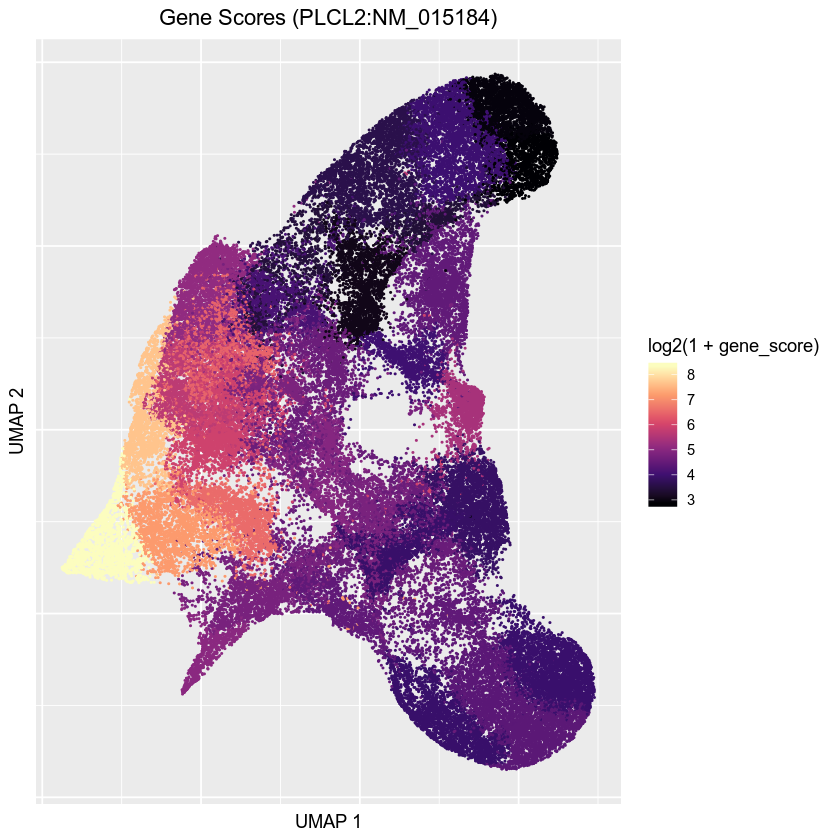

In [1720]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, gene_score=as.numeric(data.use[GENE, ])[clusters])
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=log2(1+gene_score))) +
ggtitle(sprintf("Gene Scores (%s)", GENE)) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(oob=squish, option = "A") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

In [1731]:
ALL_PEAKS_BED_PATH = "tmp.txt"
fileConn = file(ALL_PEAKS_BED_PATH)

# write genes not in cur_diff_peaks
# cur_genes = lapply(strsplit(cur_diff_peaks, ":"), "[[", 1)
cur_genes = rna_genes_subset
remaining_genes = edb.genes.hg38$gene_name[!edb.genes.hg38$gene_name %in% cur_genes]
writeLines(unique(c(unlist(cur_genes), remaining_genes)), fileConn)
# writeLines(unique(c(unlist(cur_genes))), fileConn)
# writeLines(sub("-", "\t", sub(":", "\t", (cur_diff_peaks)[1:5000])), fileConn)

close(fileConn)

In [1594]:
ALL_PEAKS_BED_PATH = "tmp_all.txt"
fileConn = file(ALL_PEAKS_BED_PATH)
writeLines(edb.genes.hg38$gene_name, fileConn)
close(fileConn)

## Locus Level Analyses (Vignettes)
Analyses a bunch of gene clusters or regions to see aggregate signal in them. Usually doesn't work at single-cell level because regions are not large enough.

In [130]:
peaks_gr = GRanges(rownames(norm_cts))

### Type I Keratin Gene Cluster

Rough coordinates chr17:40801459-41629596. 

In [1403]:
region = "chr17:40801459-41629596"
region_gr = GRanges(c(region))

In [1404]:
norm_reads_in_region = colSums(norm_cts[unique(queryHits(findOverlaps(peaks_gr, region_gr))), ])

In [1405]:
max(norm_reads_in_region)
median(norm_reads_in_region)
min(norm_reads_in_region)
max(norm_reads_in_region)/min(norm_reads_in_region)

[1] 7182.931

[1] 2213.267

[1] 1769.294

[1] 4.059772

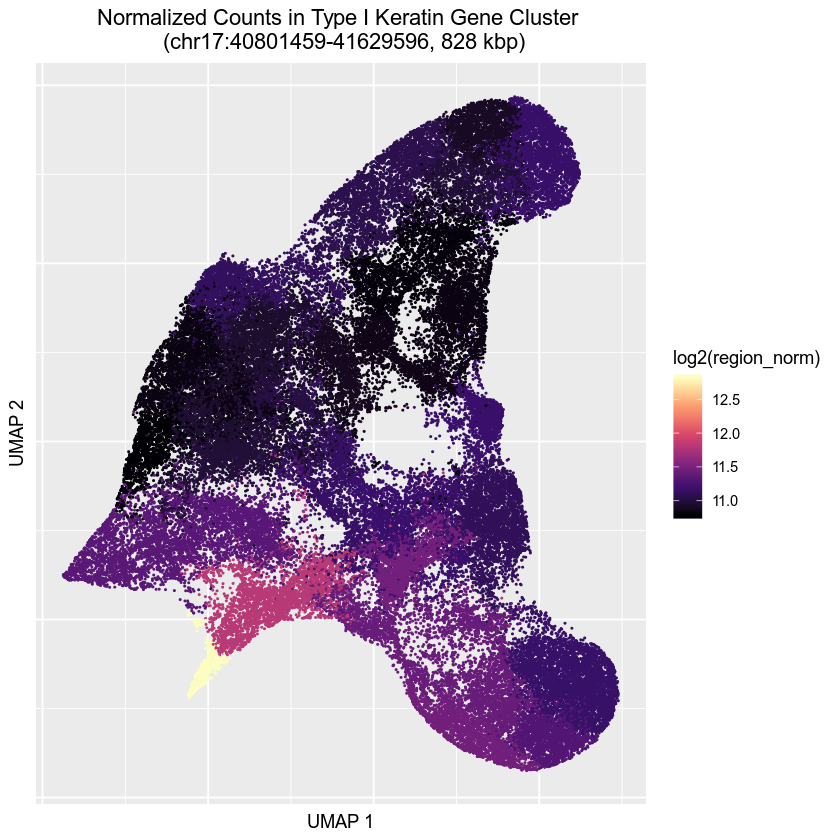

In [1406]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, region_norm=norm_reads_in_region[clusters])
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=log2(region_norm))) +
ggtitle(sprintf("Normalized Counts in Type I Keratin Gene Cluster \n (%s, %d kbp)", region, 
               as.integer(width(region_gr)/1000))) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(oob=squish, option = "A") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

### Type II Keratin Gene Cluster

In [1399]:
region = "chr12:52138667-52987560"
region_gr = GRanges(c(region))

In [1400]:
norm_reads_in_region = colSums(norm_cts[unique(queryHits(findOverlaps(peaks_gr, region_gr))), ])

In [1401]:
max(norm_reads_in_region)
median(norm_reads_in_region)
min(norm_reads_in_region)
max(norm_reads_in_region)/min(norm_reads_in_region)

[1] 18640.46

[1] 9687.823

[1] 7930.4

[1] 2.350507

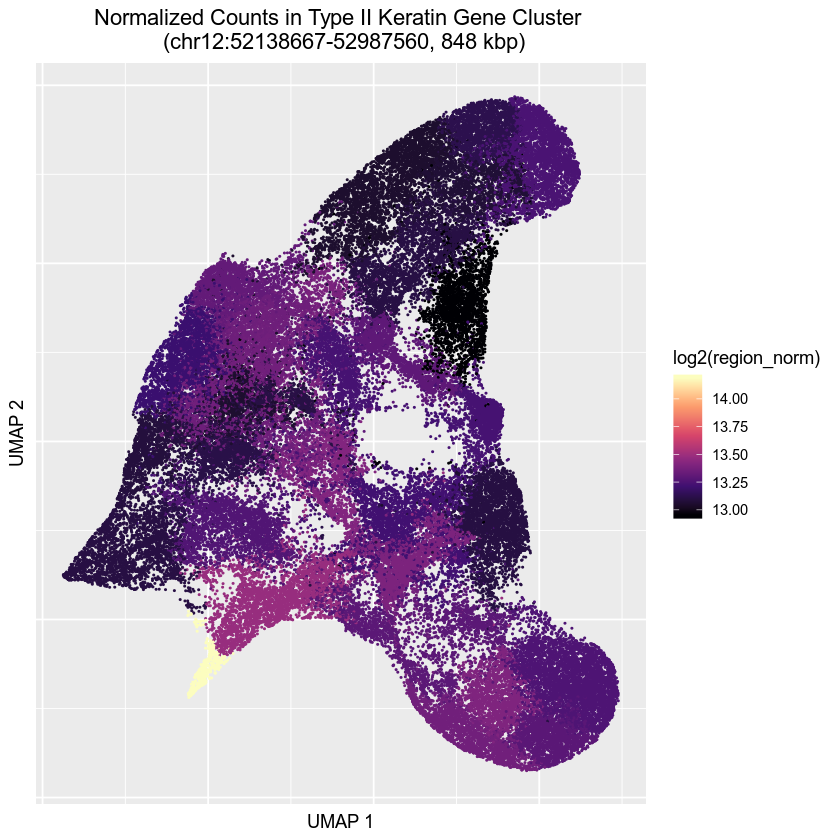

In [1402]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, region_norm=norm_reads_in_region[clusters])
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=log2(region_norm))) +
ggtitle(sprintf("Normalized Counts in Type II Keratin Gene Cluster \n (%s, %d kbp)", region, 
               as.integer(width(region_gr)/1000))) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(oob=squish, option = "A") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

### Type 1 Interferon Locus

In [678]:
region = "chr9:21053568-21498318"
region_gr = GRanges(c(region))

In [679]:
norm_reads_in_region = colSums(norm_cts[unique(queryHits(findOverlaps(peaks_gr, region_gr))), ])

In [680]:
max(norm_reads_in_region)
median(norm_reads_in_region)
min(norm_reads_in_region)
max(norm_reads_in_region)/min(norm_reads_in_region)

[1] 3361.933

[1] 1736.506

[1] 1327.96

[1] 2.531652

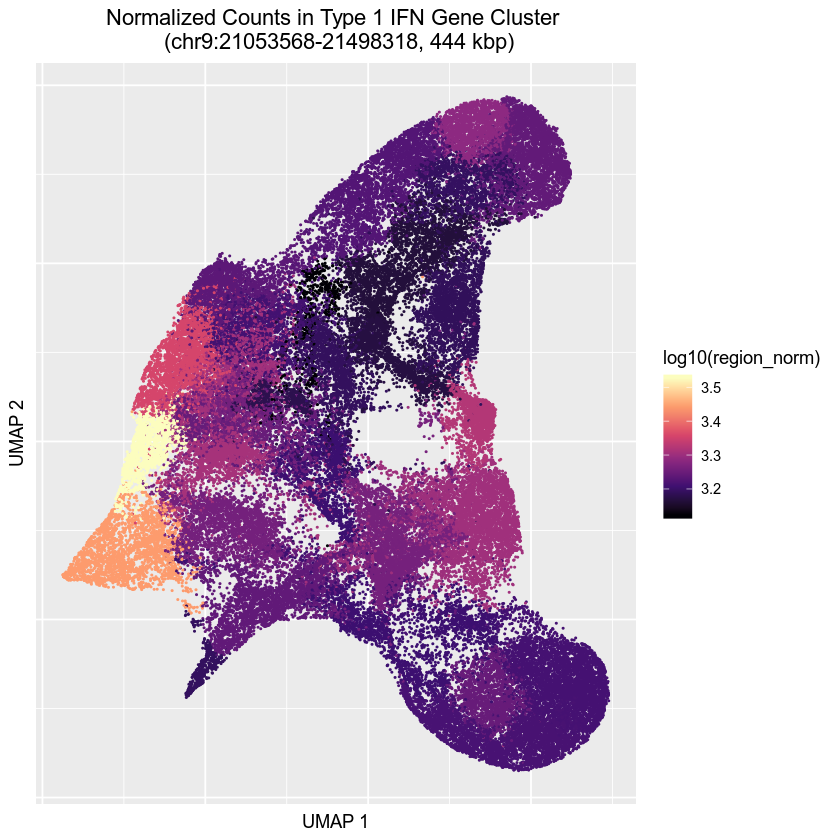

In [616]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, region_norm=norm_reads_in_region[clusters])
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=log10(region_norm))) +
ggtitle(sprintf("Normalized Counts in Type 1 IFN Gene Cluster \n (%s, %d kbp)", region, 
               as.integer(width(region_gr)/1000))) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(oob=squish, option = "A") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

### Promoters of Olfactory Receptor Genes

In [135]:
prom.hg38 = promoters(genes.hg38, upstream = 2000, downstream = 500)
seqlevels(prom.hg38) = paste("chr", seqlevels(prom.hg38), sep='')

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
"GRanges object contains 1 out-of-bound range located on sequence MT.
  Note that ranges located on a sequence whose length is unknown (NA) or
  on a circular sequence are not considered out-of-bound (use
  seqlengths() and isCircular() to get the lengths and circularity flags
  of the underlying sequences). You can use trim() to trim these ranges.
  See ?`trim,GenomicRanges-method` for more information."


In [1617]:
region_gr = prom.hg38[(grepl("^OR[0-9]", prom.hg38$gene_name)),]

In [1367]:
# total olfactory receptors 
length(region_gr)

# those that intersect with any peaks
length(unique(subjectHits(findOverlaps(peaks_gr, region_gr))))

[1] 471

[1] 35

In [1626]:
norm_reads_in_region = colSums(norm_cts[unique(queryHits(findOverlaps(peaks_gr, region_gr))), ])

In [1627]:
max(norm_reads_in_region)
median(norm_reads_in_region)
min(norm_reads_in_region)
max(norm_reads_in_region)/min(norm_reads_in_region)

[1] 1344.773

[1] 423.642

[1] 287.719

[1] 4.673912

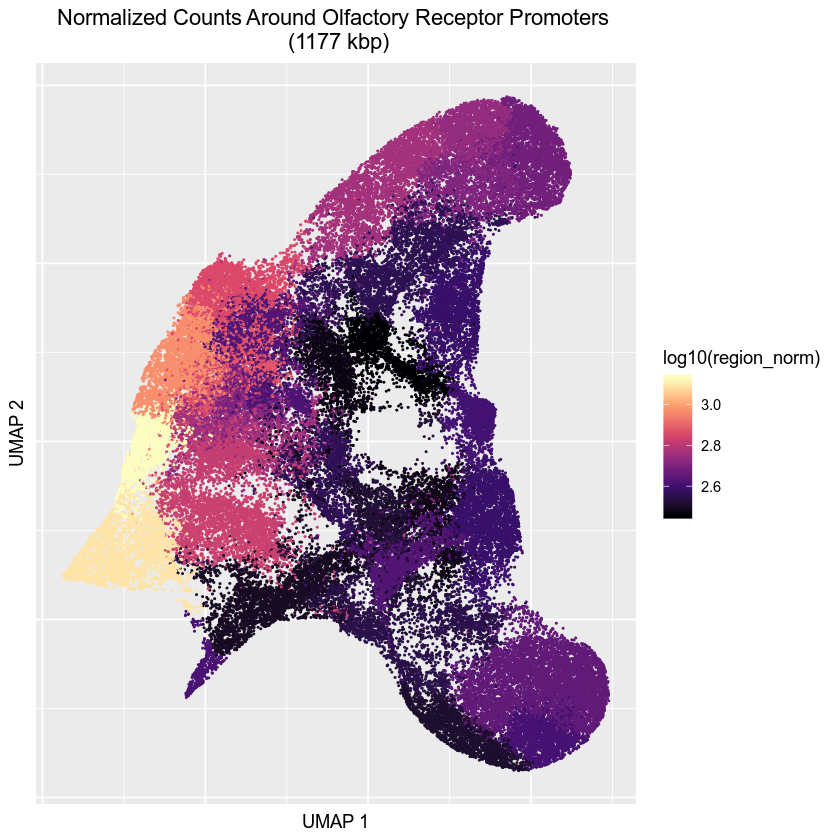

In [1628]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, region_norm=norm_reads_in_region[clusters])
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=log10(region_norm))) +
ggtitle(sprintf("Normalized Counts Around Olfactory Receptor Promoters \n (%d kbp)", 
               as.integer(sum(width(region_gr))/1000))) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(oob=squish, option = "A") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

### Soufi et al "DBR" Heterochromatin Regions

These were regions identified in Soufi et al 2012 that were recfractory to OSKM binding in fibroblasts and are marked by H3K9me3, and are required for reprogramming. This can be done at single-cell level since it is 500 Mbp combined.

In [1000]:
region_gr = read.table("../../../resources/GSE36570/DBRs.hg38.bed")
colnames(region_gr) = c("chr", "start", "end")
region_gr = makeGRangesFromDataFrame(region_gr)

In [ ]:
norm_reads_in_region = Matrix::rowSums(x.sp@pmat[, unique(queryHits(findOverlaps(GRanges(as.character(x.sp@peak)), region_gr)))])/Matrix::rowSums(x.sp@pmat)

In [135]:
max(norm_reads_in_region)
median(norm_reads_in_region)
min(norm_reads_in_region)
max(norm_reads_in_region)/min(norm_reads_in_region)

[1] 2

[1] 0

[1] 0

[1] Inf

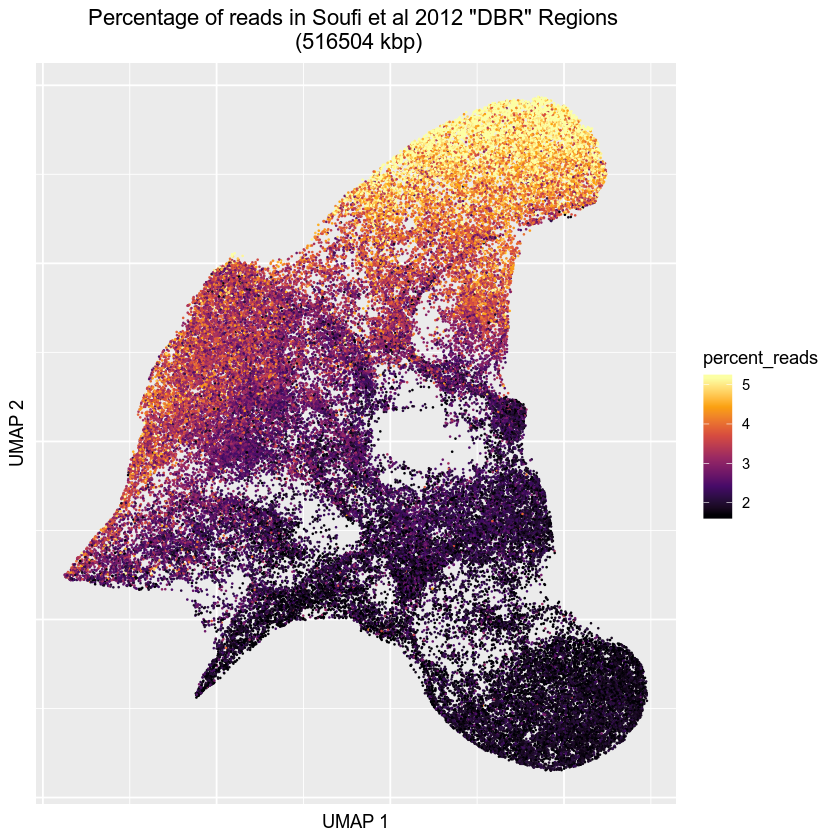

In [677]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, percent_reads=100*norm_reads_in_region)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.1, alpha=1, aes(x=umap.1 , y=umap.2, col=percent_reads)) +
ggtitle(sprintf("Percentage of reads in Soufi et al 2012 \"DBR\" Regions \n (%d kbp)",  
               as.integer(sum(width(region_gr))/1000))) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(limits=c(quantile(100*norm_reads_in_region, 0.1), 
                               quantile(100*norm_reads_in_region, 0.95)), 
                      oob=squish, option = "B") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

### Reads in Clustered Peak Sets

In [47]:
pmatRowSums = Matrix::rowSums(x.sp@pmat)

In [1764]:
fnames = c("../20200307_fine_clustering/beds/20200330_gridmap_peakwidthnorm_n20/idx5.bed")
# fnames = c("../20200331_gc_stratify/beds/20200403_fibr_cluster6_lt_0.2_quantile_gc10/gc_0.1_0.32.bed",
#           "../20200331_gc_stratify/beds/20200403_fibr_cluster6_lt_0.2_quantile_gc10/gc_0.32_0.35.bed")
# fnames = c("./tmp.bed")
# fnames = list(gzfile("/oak/stanford/groups/akundaje/surag/GEO/GSE36570/croo/SRR445817/peak/idr_reproducibility/idr.optimal_peak.narrowPeak.gz"))

region_gr = read.table(fnames[[1]])

if (length(fnames)>1) {
    for (i in seq(2, length(fnames))) {
        region_gr = rbind(region_gr, read.table(fnames[[i]]))
    }
}
# region_gr = read.table("../20200304_transient_peaks/beds/20200305_heatmap_bulk_n15/idx1.bed")
# region_gr = read.table("./beds/20200328_tmp_n20/idx14.1000bp.bed")
colnames(region_gr) = c("chr", "start", "end")
region_gr = makeGRangesFromDataFrame(region_gr)

In [1765]:
# region_gr = GRanges((cur_diff_peaks)[1:10000])

In [1766]:
norm_reads_in_region = Matrix::rowSums(x.sp@pmat[, unique(queryHits(findOverlaps(GRanges(as.character(x.sp@peak)), region_gr)))])/pmatRowSums

In [1767]:
max(norm_reads_in_region)
median(norm_reads_in_region)
min(norm_reads_in_region)
max(norm_reads_in_region)/min(norm_reads_in_region)

[1] 0.1744349

[1] 0.002873039

[1] 0

[1] Inf

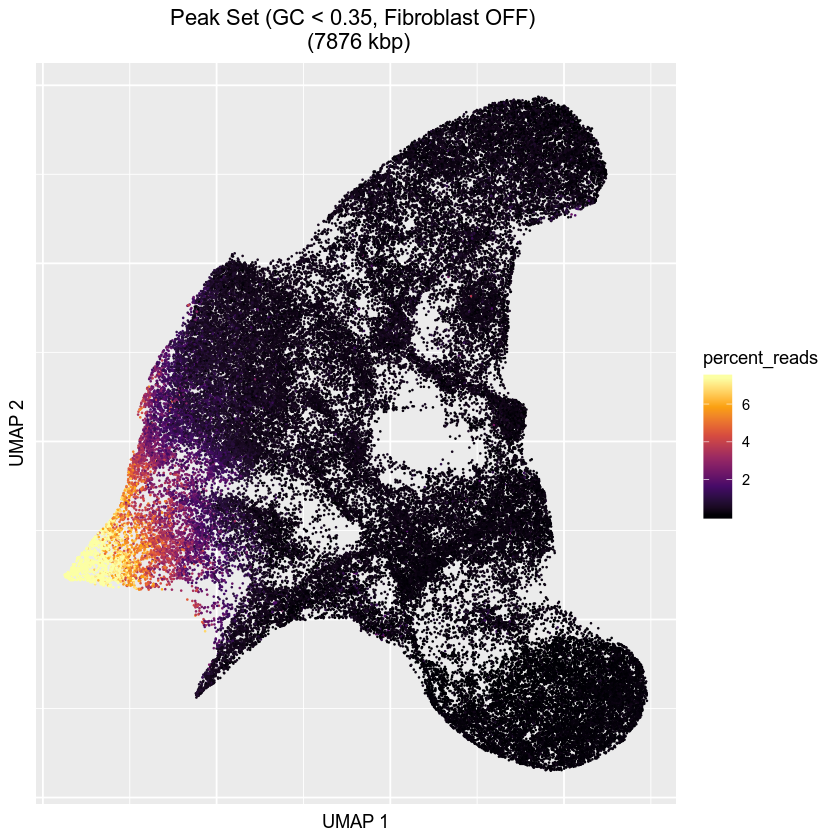

In [1768]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, percent_reads=100*norm_reads_in_region)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$percent_reads<2, ]) +
geom_point(size=0.1, alpha=1, aes(x=umap.1 , y=umap.2, col=percent_reads)) +
ggtitle(sprintf("Peak Set (GC < 0.35, Fibroblast OFF) \n (%d kbp)",  
               as.integer(sum(width(region_gr))/1000))) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(limits= c(quantile(100*norm_reads_in_region, 0.1), 
                              quantile(100*norm_reads_in_region, 0.99)), 
                      oob=squish, option = "B") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

### Reads in One/Few Peaks 

In [910]:
# is single or few bins
region = "chr17:50201140-50203639"
region_gr = GRanges(c(region))

In [911]:
intersection_idxs = unique(queryHits(findOverlaps(GRanges(as.character(x.sp@peak)), region_gr)))
intersection_idxs

[1] 179394

In [912]:
num_reads_in_region = x.sp@pmat[, intersection_idxs]
# num_reads_in_region = Matrix::rowSums(x.sp@pmat[, intersection_idxs])

In [913]:
max(num_reads_in_region)

[1] 4

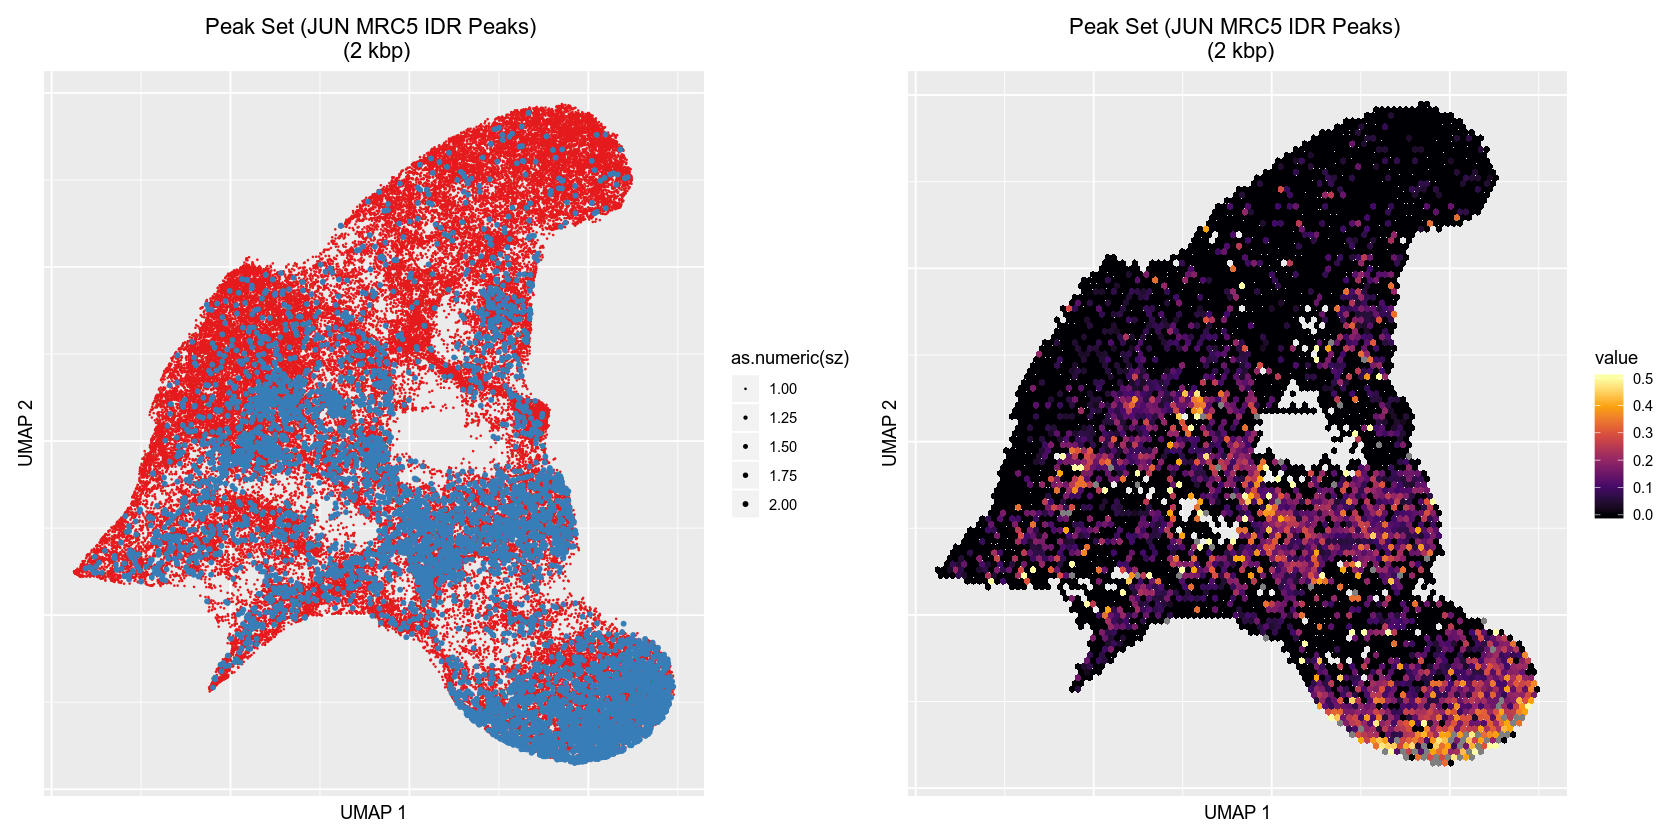

In [914]:
df = data.frame(x.sp@umap, percent_reads=num_reads_in_region)
df$sz = ifelse(df$percent_reads>0, 2, 1)
# bring to top
df = df[order(df$percent_reads), ]

# BINARY READS: BIGGER DOTS FOR CELLS WITH >0 READ IN REGION
plot1 <- ggplot(df) +
# ggplot(df[df$percent_reads<2, ]) +
geom_point(alpha=1, aes(x=umap.1 , y=umap.2, col=percent_reads>0, size=as.numeric(sz))) +
ggtitle(sprintf("Peak Set (JUN MRC5 IDR Peaks) \n (%d kbp)",  
               as.integer(sum(width(region_gr))/1000))) + 
xlab("UMAP 1") + ylab("UMAP 2") +
# scale_color_viridis_c(limits= c(quantile(100*norm_reads_in_region, 0.1), 
#                                quantile(100*norm_reads_in_region, 0.95)), 
#                       oob=squish, option = "B") +
scale_color_brewer(breaks=DAYS, palette = "Set1") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())+
scale_size_continuous(range = c(0.1, 1))

df = data.frame(x.sp@umap, num_reads=num_reads_in_region)
df$sz = ifelse(df$num_reads>0, .2, 0.1)
# shuffle so days don't overlap
df = df[order(df$num_reads), ]
df_nonzero = df[df$num_reads>0, ]

# AGGREGATE READS: SUM RAW READS IN PEAKS IN UMAP SPACE 
plot2 <- ggplot(df, aes(x=umap.1 , y=umap.2, z=num_reads)) +
# geom_point(alpha=1, , size=0.1) +
stat_summary_hex(bins=100) +
# stat_bin2d(data=df_nonzero, aes(x=umap.1 , y=umap.2), bins=100) +
ggtitle(sprintf("Peak Set (JUN MRC5 IDR Peaks) \n (%d kbp)",  
               as.integer(sum(width(region_gr))/1000))) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_fill_viridis_c(limits=c(0,0.5), option="B") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())+
scale_size_continuous(range = c(0.1, .5))


options(repr.plot.width = 14, repr.plot.height = 7)
plot1 | plot2

### Colouring by Old Clusters

In [773]:
# using old metadata to annotate (these clusters were used to call peaks)

# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
old_metaData = read.table("../20200122_snapATAC/snapATAC_sessions/20200125_n76770/metadata.tsv", header = T)
rownames(old_metaData) =  paste(old_metaData$sample, old_metaData$barcode, sep='_')
old_metaData = old_metaData[rownames(metaData), ]
head(old_metaData, 2)

barcode          cluster umap1    umap2    barcode.1       
D0_AAACAACGACGATTAC AAACAACGACGATTAC 6       2.515876 8.252824 AAACAACGACGATTAC
D0_AAACAACGACTCACGG AAACAACGACTCACGG 6       2.355841 7.403916 AAACAACGACTCACGG
                    TN    UM    PP    UQ    CM landmark cluster.1 sample
D0_AAACAACGACGATTAC 42629 38455 38381 33575 51 0        6         D0    
D0_AAACAACGACTCACGG  4424  4009  3998  3694  4 0        6         D0

In [774]:
sum(is.na(old_metaData$cluster.1))

[1] 330

Warning message:
"Removed 330 rows containing missing values (geom_point)."


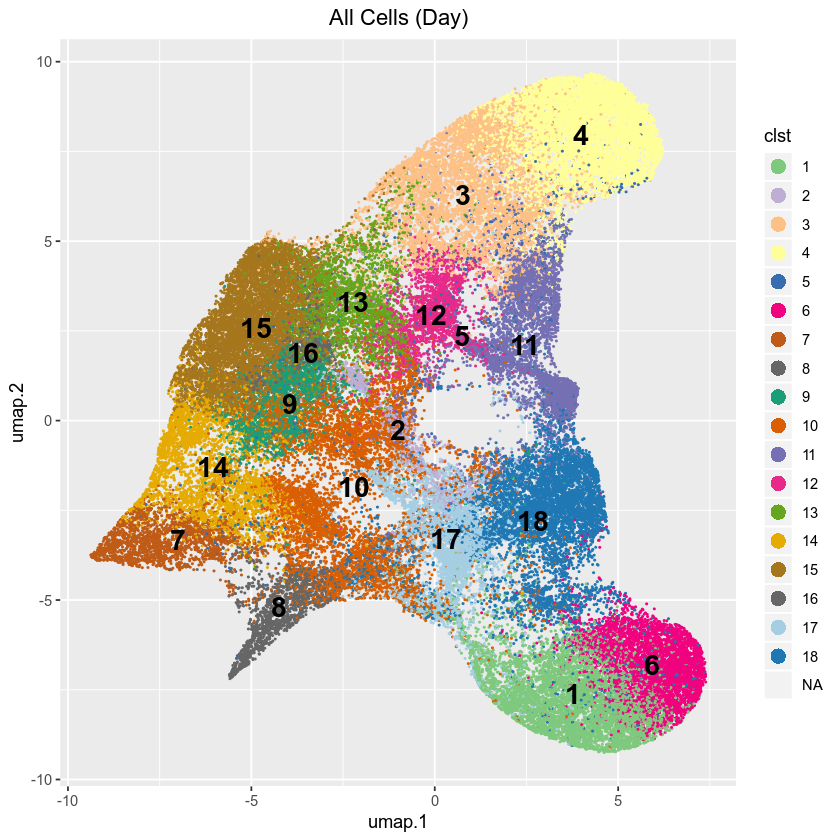

In [1283]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, clst=as.factor(old_metaData$cluster.1))
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=clst)) +
# scale_color_brewer( palette = "Set1") +
scale_color_manual(values=col_vector) +
geom_text(data=data.frame(aggregate(x.sp@umap, list(old_metaData$cluster.1), mean)),
         aes(x=umap.1, y=umap.2, label=Group.1), size=6, fontface = "bold") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) +
#       legend.positio = "none")
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

## D0 Diff Peaks

In [1728]:
data.use = cts[, c("cluster_1", "cluster_8")]
group = factor(colnames(data.use), levels = colnames(data.use))
design = model.matrix(~0+group)
y = DGEList(counts=data.use, group=group)
et = exactTest(y, dispersion = 0.4^2)
cur_diff_peaks = rownames(et$table[order((1/et$table$PValue)*ifelse(et$table$logFC>0, 1, -1)),])  

In [1113]:
frac_in_peakset = Matrix::rowSums(x.sp@pmat[, as.character(x.sp@peak) %in% cur_diff_peaks[1:10000]])/pmatRowSums

In [1114]:
frac_in_peakset_rev = Matrix::rowSums(x.sp@pmat[, as.character(x.sp@peak) %in% rev(cur_diff_peaks)[1:10000]])/pmatRowSums

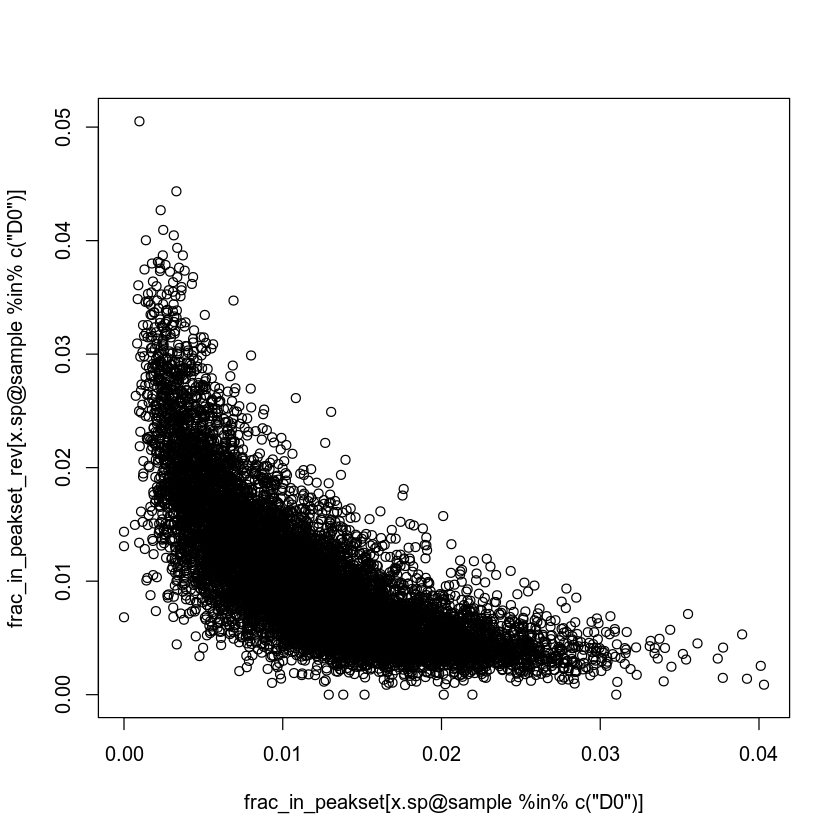

In [1115]:
plot(frac_in_peakset[x.sp@sample %in% c("D0")], frac_in_peakset_rev[x.sp@sample %in% c("D0")])

In [1723]:
options(repr.plot.width = 7, repr.plot.height = 7)
selected_cluster_id = 10

twoplots = list()
i=1
cur_days = DAYS #c("D0", "D2")
for (toplot in list(frac_in_peakset, frac_in_peakset_rev)) {

    # df = data.frame(x.sp@umap, accs=km_mb$centroids[selected_cluster_id, ][clusters])
    cur_selected = toplot[x.sp@sample %in% cur_days]
    cur_med = quantile(cur_selected, 0.5)

    # or a specific peak
    # df = data.frame(x.sp@umap, accs=log2(1+colSums(norm_cts[rev(cur_diff_peaks)[1:1000], ]))[clusters])
    df = data.frame(x.sp@umap, x.sp@sample, frip=toplot)
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1]), ]

    # ggplot(df) +
    twoplots[[i]] <- ggplot(df[df$x.sp.sample %in% cur_days, ]) +
    geom_point(size=0.1, alpha=1, aes(x=umap.1 , y=umap.2, col=frip)) +
    ggtitle(sprintf("Fraction of Reads in Peak Set %d (per cell)", i)) + 
    xlab("UMAP 1") + ylab("UMAP 2") +
    scale_color_viridis_c(limits=c(quantile(cur_selected, 0.1), 
                                   quantile(cur_selected, 0.99)), oob=squish, option = "A") +
    theme(plot.title = element_text(hjust = 0.5))
    
    i = i+1
}

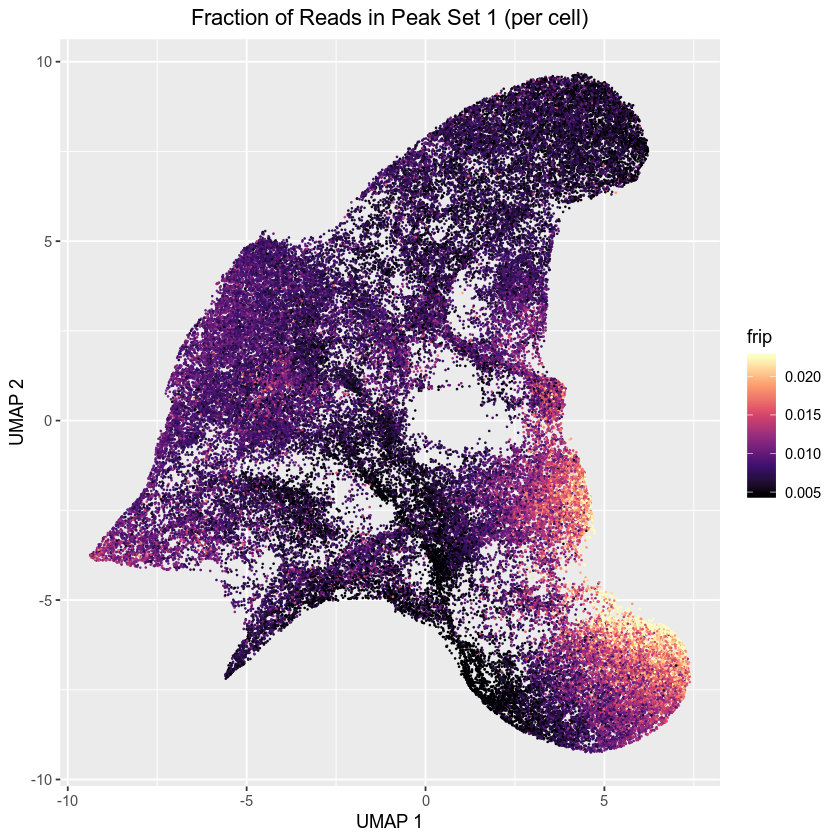

In [1726]:
options(repr.plot.width = 7, repr.plot.height = 7)
twoplots[[1]]